In [2]:
cd /home

/home


In [31]:
import matplotlib.pyplot as plt 
import tensorflow as tf

from src.layers.attention import scaled_dot_product_attention

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
num_head = 4
window_size = 100
head_dim = 32

Q = tf.random.normal([1, num_head, window_size, head_dim])
K = tf.random.normal([1, num_head, window_size, head_dim])
V = tf.random.normal([1, num_head, window_size, head_dim])

mask = tf.concat([tf.ones(10), tf.zeros(90)], 0)
mask = tf.reshape(mask, [1, -1, 1])

In [143]:
alphasneg = tf.linspace(-1e9, 1, 100)
alphaspos = tf.linspace(1., 1e9, 100)

alphas = tf.concat([alphasneg, alphaspos], axis=0)

In [144]:

ratios = []
for alp in alphas:

    scaled_attention, \
    attention_weights = scaled_dot_product_attention(Q, K, V, mask=mask, alpha=alp)

    mean_mask = tf.reduce_mean(attention_weights[0, 0, :10])
    mean_rest = tf.reduce_mean(attention_weights[0, 0, 10:])
    
    ratios.append(mean_mask)

Text(0, 0.5, '$e^{QK + M\\alpha}$')

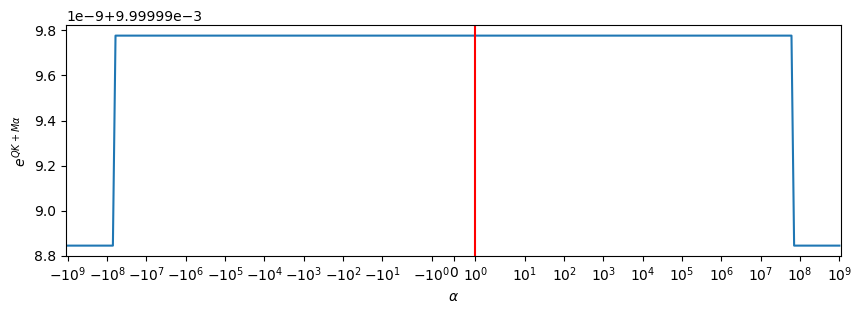

In [146]:
plt.figure(figsize=(10,3))
plt.plot(alphas, ratios)
plt.axvline(x=1, color='red', label='Bugstromer')
plt.xscale('symlog')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$e^{QK + M\alpha}$')

In [132]:
tf.reduce_max(ratios)

<tf.Tensor: shape=(), dtype=float32, numpy=0.010000001>